In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision = 3, suppress = True)

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from keras import backend as K

class BiasLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(BiasLayer, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        print(input_shape)
        self.bias = self.add_weight('bias',
                                    shape=input_shape[1:],
                                    initializer='glorot',
                                    trainable=True)
    def call(self, x):
        return x + self.bias

class ConstantTensorInitializer(tf.keras.initializers.Initializer):
  """Initializes tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, shape, dtype=None):
    return self.t

  def get_config(self):
    return {'t': self.t}

class ConstantTensorConstraint(tf.keras.constraints.Constraint):
  """Constrains tensors to `t`."""

  def __init__(self, t):
    self.t = t

  def __call__(self, w):
    return self.t

  def get_config(self):
    return {'t': self.t}

# all you need to create a mask matrix M, which is a NxN identity matrix
# and you can write a contraint like below
class DiagonalWeight(tf.keras.constraints.Constraint):
    """Constrains the weights to be diagonal.
    """
    def __call__(self, w):
        N = K.int_shape(w)[-1]
        m = K.eye(N)
        v = w*m
        return v

In [4]:
def init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim):

    # Append hidden layers
    all_layers = []

    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    input_model = tf.keras.layers.InputLayer(input_shape= (input_dim,), name='input_model')
    model.add(input_model)

    # Construct first omega matrix
    omega_each_dim = omega*np.ones((input_dim,1))
    Omega_matrix = np.array([])

    for dim in range(input_dim):
        Omega_dim = np.zeros((m_periodic, input_dim))
        Omega_dim[:,dim] = omega_each_dim[dim,0]*np.ones((m_periodic,))
        Omega_matrix = np.vstack([Omega_matrix,Omega_dim]) if Omega_matrix.size else Omega_dim

    Omega = tf.Variable(Omega_matrix.T,dtype=tf.float32)

    # Create first C^inf periodic layers L_p(m,n)
    first_periodic_layer = tf.keras.layers.Dense(m_periodic*input_dim,
                                                 activation = tf.math.cos,
                                                 use_bias = True,
                                                 trainable = True,
                                                 name = 'first_periodic_layer',
                                                 kernel_initializer = ConstantTensorInitializer(Omega),
                                                 kernel_constraint = ConstantTensorConstraint(Omega),
                                                 bias_initializer = 'glorot_normal')
    all_layers.append(first_periodic_layer)
    model.add(first_periodic_layer)

    second_periodic_layer = tf.keras.layers.Dense(m_periodic*input_dim,
                                                  activation = 'tanh',
                                                  use_bias = True,
                                                  trainable = True,
                                                  name = 'second_periodic_layer',
                                                  kernel_constraint = DiagonalWeight(),
                                                  kernel_initializer = 'glorot_normal',
                                                  bias_initializer = 'glorot_normal')
    all_layers.append(second_periodic_layer)
    model.add(second_periodic_layer)

    # create the rest of the network (substitute other code here also)
    for layer in range(nb_hidden_layers):
        if layer == nb_hidden_layers-1:
            layer_name = 'first_to_last_hidden_layer'
        else:
            layer_name = 'hidden_layer_' + str(layer)

        hidden_layer = tf.keras.layers.Dense(nb_nodes_per_layer, 
                                        activation='tanh',
                                        name=layer_name,
                                        kernel_initializer= 'glorot_normal')
                                        #bias_initializer= weight_bias_initializer,
                                        #dtype=tf.float32)
        all_layers.append(hidden_layer)
        model.add(hidden_layer)

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

## high-dimensional second order equation $-\nabla \cdot \left((1+\frac{1}{4}\sin {2\pi x_1}\sin {2\pi x_2})\nabla \Psi\right) + \nu \Psi=- 2\pi^2 \cos{2\pi x_1}\cos{4\pi x_1}\sin^2 {2\pi x_2} - \pi^2 \sin{2\pi x_1}\sin{4\pi x_1}\cos^2 {2\pi x_2} + 20\pi^2(1+\frac{1}{4}\sin {2\pi x_1}\sin {2\pi x_2})\sin{4\pi x_1}\sin{4\pi x_2} + \nu \sin{4\pi x_1}\sin{2\pi x_2}$ with periodic BCs

## Exact solution: $\Psi(x) = \sin{4\pi x_1} \sin{2\pi x_2}$

In [5]:
nb_hidden_layers = 3
nb_nodes_per_layer = 30

input_dim = 6
m_periodic = 11
n_periodic = 30

L_period = 1.0 #2*np.pi
omega = 2*np.pi/L_period
# Initialize model aka u_\theta
model5 = init_model(nb_hidden_layers, nb_nodes_per_layer, m_periodic, n_periodic, omega, input_dim)
model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_periodic_layer (Dense) (None, 66)                462       
_________________________________________________________________
second_periodic_layer (Dense (None, 66)                4422      
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 30)                2010      
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 30)                930       
_________________________________________________________________
first_to_last_hidden_layer ( (None, 30)                930       
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 8,785
Trainable params: 8,785
Non-trainable params: 0
______________________________________________________

## Sampling

In [6]:
a = 0
b = 1
N = 2000

nu = 0.5

# Monte Carlo points in the domain

input_data_MC = np.random.uniform(0 ,1, (N,input_dim))

## Define the diffusion function and its derivatives here

In [7]:
def diffusion_fcns(x):
    diffusion = 1 + 1/4 * np.sin(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
    L,x_dim = np.shape(x)
    grad_diffusion = [np.zeros_like(x[:, 0])] * x_dim
    grad_diffusion[0] = np.pi/2 * np.cos(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
    grad_diffusion[1] = np.pi/2 * np.sin(2*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])
    return diffusion, grad_diffusion

## Exact solution and its gradient and divergence

In [8]:
# Define the exact solution
def exact_solu(x):
    y = np.sin(4*np.pi*np.double(x[:, 0])) * np.sin(2*np.pi*np.double(x[:, 1]))
    return y

In [9]:
# Compute the gradient and divergence of the exact solution numerically
def exact_grad_div(x):
    L,x_dim = np.shape(x)
    dx = np.double(0.003)
    gradient = [np.zeros_like(x[:, 0])] * x_dim
    divergence = np.zeros_like(x[:, 0])
    
    for i in range(x_dim):
        dx_i = np.zeros_like(x);
        dx_i[:, i] = 1;
        
            
        # six-order finite difference
        gradient[i] = (-1/60 * exact_solu(x - 3*dx*dx_i) + 3/20 * exact_solu(x - 2*dx*dx_i) - 3/4 * exact_solu(x - dx*dx_i) + 3/4 * exact_solu(x + dx*dx_i) - 3/20 * exact_solu(x + 2*dx*dx_i) + 1/60 * exact_solu(x + 3*dx*dx_i)) / dx
        divergence = divergence + ((1/90) * exact_solu(x - 3*dx*dx_i) -(3/20) * exact_solu(x - 2*dx*dx_i) + (3/2) * exact_solu(x - dx*dx_i) - (49/18) * exact_solu(x) + (3/2) * exact_solu(x + dx*dx_i) - (3/20) * exact_solu(x + 2*dx*dx_i) +(1/90) * exact_solu(x + 3*dx*dx_i)) / dx**2
#         if (i == 0):
#             print((1/90 * np.sin(4*np.pi*(x[:, 0]-3*dx)) * np.sin(2*np.pi*x[:, 1]) -3/20 * np.sin(4*np.pi*(x[:, 0]-2*dx)) * np.sin(2*np.pi*x[:, 1]) + 3/2 * np.sin(4*np.pi*(x[:, 0]-dx)) * np.sin(2*np.pi*x[:, 1]) - 49/18 * np.sin(4*np.pi*(x[:, 0])) * np.sin(2*np.pi*x[:, 1]) + 3/2 * np.sin(4*np.pi*(x[:, 0]+dx)) * np.sin(2*np.pi*x[:, 1]) - 3/20 * np.sin(4*np.pi*(x[:, 0]+2*dx)) * np.sin(2*np.pi*x[:, 1]) +1/90 * np.sin(4*np.pi*(x[:, 0]+3*dx)) * np.sin(2*np.pi*x[:, 1])) / dx**2 - (- 16 *np.pi**2 * np.sin(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])))
        
    gradient0 = 4 * np.pi * np.cos(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
    gradient1 = 2 * np.pi * np.sin(4*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])
    divergence1 = - 20 * np.pi**2 * np.sin(4*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])
#     print(norm(divergence1-divergence))
    
    return gradient, divergence

In [10]:
def trainStep_N_dimension(x, diffusion_x, grad_diffusion_x, exact_x, exact_grad_x, exact_div_x, opt, model):
    
    L,x_dim = np.shape(x)
    
    # Outer gradient for model parameters
    with tf.GradientTape() as tape:
        
        # Inner gradient for first derivative of N wrt x
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch(x)
            
            # Inner inner gradient for fi derivative of N wrt x
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x)
            
                N = model(x)
            
            # Gradient of the NN
            grad_N = tape2.gradient(N, x)
            grad_N_i = []
            for i in range(x_dim):
                grad_N_i.append(grad_N[: ,i])
        # Divergence of the NN
        div_N = tf.zeros([L])
        for i in range(x_dim):
            div_N = div_N + tape1.gradient(grad_N_i[i], x)[:, i]
        
            
        
        N = tf.reshape(N, [L])
        
        grad_error = [np.zeros_like(x[:, 0])] * x_dim
        
        # Plug trial solution into ODE:
        divergence_error = div_N - exact_div_x
#         grad_error[0] = grad_N[:, 0] - exact_grad_x[0]
#         grad_error[1] = grad_N[:, 1] - exact_grad_x[1]
        N_error = N - exact_x
        
#         eqn = - (1 + 1/4 * np.sin(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) *  divergence_error - \
#         (np.pi/2 * np.cos(2*np.pi*x[:, 0]) * np.sin(2*np.pi*x[:, 1])) * grad_error[0] - \
#         (np.pi/2 * np.sin(2*np.pi*x[:, 0]) * np.cos(2*np.pi*x[:, 1])) * grad_error[1] + nu * N_error
        
        eqn = - diffusion_x *  divergence_error  + nu * N_error 
        for i in range(x_dim):
            grad_error[i] = grad_N[:, i] - exact_grad_x[i]
            eqn = eqn - grad_diffusion_x[i] * grad_error[i]
        
        loss = tf.reduce_sum(tf.square(eqn)) 
        N_loss = tf.reduce_sum(tf.square(N_error))
        gradient_loss = tf.square(grad_error[x_dim-1])
        for i in range(x_dim-1):
            gradient_loss = gradient_loss + tf.square(grad_error[i])
        gradient_loss = tf.reduce_sum(gradient_loss)
        divergence_loss = tf.reduce_sum(tf.square(divergence_error))
        
    # Compute the gradient of loss wrt model parameters
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Gradient step
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    
    return loss, N_loss, gradient_loss, divergence_loss

In [11]:
def PINNtrain(x, epochs, model):
    
    # optional, use a stopping tolerance (i.e., if loss < 1e-7 then stop training early)
    stop_tol = 1e-12
    
    # set the initial best loss seen so far to something large
    best_loss = 1e12
    best_loss_epoch = -1
    best_weights = None
    
    # Define an optimizer
    lr = tf.keras.optimizers.schedules.PolynomialDecay(0.1, epochs, 1e-4)
    opt = keras.optimizers.Adam()
    epoch_loss, N_loss, gradient_loss, divergence_loss = (np.zeros(epochs) for i in range(4))
    
    # Calculate diffusion function, forcing term at sample points x in double precision
    diffusion_x, grad_diffusion_x = diffusion_fcns(np.double(x.numpy()))
    exact_x = exact_solu(np.double(x.numpy()))
    exact_grad_x, exact_div_x = exact_grad_div(np.double(x.numpy()))
    
    # Main training loop
    for i in range(epochs):
        
        epoch_loss[i], N_loss[i], gradient_loss[i], divergence_loss[i]  = trainStep_N_dimension(x, diffusion_x, grad_diffusion_x, exact_x, exact_grad_x, exact_div_x, opt, model)
        
        if (np.mod(i, 100)==0):
          print("PDE loss in {}th epoch: {: 1.6e}. Last save epoch and best loss so far: {}, {: 1.6e}.".format(i, epoch_loss[i], best_loss_epoch, best_loss))
    
        if (epoch_loss[i] < best_loss):
            best_weights = model.get_weights()
            best_loss_epoch = i
            best_loss = epoch_loss[i]
            #print("Found a new best local minimum at epoch {}: loss {: 1.6e}. Saving weights.".format(i, epoch_loss[i]))
            
        if (epoch_loss[i] < stop_tol):
            print("Current model has loss {: 1.6e}, lower than stopping tolerance {: 1.6e}, stopping early at epoch {}.".format(epoch_loss[i],stop_tol,i))
            return epoch_loss, N_loss, gradient_loss, divergence_loss
    
    if (best_loss < epoch_loss[i]):
        model.set_weights(best_weights)
        print("Current loss {: 1.6e}, Best loss {: 1.6e}. Restoring best model weights.".format(epoch_loss[i],best_loss))
    else:
        print("Current loss {: 1.6e}, Best loss {: 1.6e}. Keeping current model weights.".format(epoch_loss[i],best_loss))
        
    return epoch_loss, N_loss, gradient_loss, divergence_loss

In [12]:
# train NN for Monte Carlo sample
epochs = 10000
PDE_loss1, N_loss1, gradient_loss1, divergence_loss1 = PINNtrain(tf.convert_to_tensor(input_data_MC, dtype = float), epochs, model5)


PDE loss in 0th epoch:  2.029628e+07. Last save epoch and best loss so far: -1,  1.000000e+12.
PDE loss in 100th epoch:  1.842215e+07. Last save epoch and best loss so far: 99,  1.843603e+07.
PDE loss in 200th epoch:  5.998830e+06. Last save epoch and best loss so far: 199,  6.088427e+06.
PDE loss in 300th epoch:  3.599703e+05. Last save epoch and best loss so far: 299,  3.708348e+05.
PDE loss in 400th epoch:  9.680104e+04. Last save epoch and best loss so far: 399,  9.820623e+04.
PDE loss in 500th epoch:  5.380214e+04. Last save epoch and best loss so far: 499,  5.408205e+04.
PDE loss in 600th epoch:  3.358154e+04. Last save epoch and best loss so far: 599,  3.375564e+04.
PDE loss in 700th epoch:  2.313070e+04. Last save epoch and best loss so far: 699,  2.318785e+04.
PDE loss in 800th epoch:  1.765115e+04. Last save epoch and best loss so far: 796,  1.738647e+04.
PDE loss in 900th epoch:  1.348056e+04. Last save epoch and best loss so far: 899,  1.350738e+04.
PDE loss in 1000th epoch

PDE loss in 8300th epoch:  4.863156e+02. Last save epoch and best loss so far: 8234,  4.682578e+02.
PDE loss in 8400th epoch:  1.669799e+03. Last save epoch and best loss so far: 8234,  4.682578e+02.
PDE loss in 8500th epoch:  5.128995e+02. Last save epoch and best loss so far: 8439,  4.561509e+02.
PDE loss in 8600th epoch:  5.156603e+02. Last save epoch and best loss so far: 8529,  4.463812e+02.
PDE loss in 8700th epoch:  4.678230e+02. Last save epoch and best loss so far: 8627,  4.393449e+02.
PDE loss in 8800th epoch:  4.271218e+02. Last save epoch and best loss so far: 8790,  4.222024e+02.
PDE loss in 8900th epoch:  4.352006e+02. Last save epoch and best loss so far: 8802,  4.216107e+02.
PDE loss in 9000th epoch:  4.329510e+02. Last save epoch and best loss so far: 8994,  4.110500e+02.
PDE loss in 9100th epoch:  6.403804e+02. Last save epoch and best loss so far: 9032,  4.050526e+02.
PDE loss in 9200th epoch:  4.148214e+02. Last save epoch and best loss so far: 9195,  3.991229e+02.


## Loss vs. number of epochs

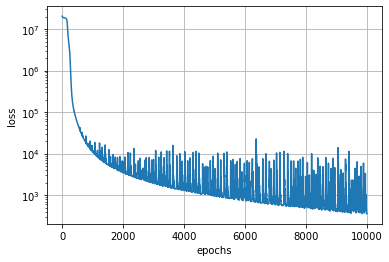

In [13]:
fig = plt.figure(1)
plt.semilogy(range(0, epochs), PDE_loss1)
plt.xlabel('epochs')
plt.ylabel('loss')

plt.grid()
plt.show()

## Errors vs. epochs

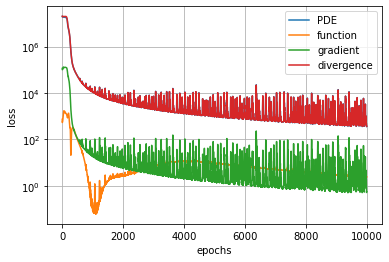

In [14]:
fig = plt.figure(2)
plt.semilogy(range(0, epochs), PDE_loss1, range(0, epochs), N_loss1, range(0, epochs), gradient_loss1, range(0, epochs), divergence_loss1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['PDE','function','gradient','divergence'])

plt.grid()
plt.show()

## Relative $L^2$ error. (Calculate using Monte-Carlo)

In [15]:
# relative L^2 error
input_data_MC = np.random.uniform(0 ,1, (2*N,input_dim))
z_model = model5(input_data_MC)
z_model = tf.reshape(z_model, [2*N])
z_exact = np.sin(4*np.pi*input_data_MC[:, 0]) * np.sin(2*np.pi*input_data_MC[:, 1])
error = np.sqrt(sum(np.square(z_model - z_exact)))/np.sqrt(sum(np.square(z_exact)))
print(error)

0.06811987763245428


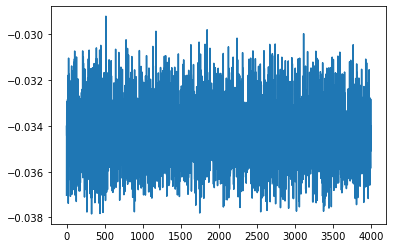

In [16]:
plt.plot(z_model-z_exact)

## Compare the NN results with the exact solution

In [17]:
# Define x3,x4,x5,x6 here
M_plot = 50
x3, x4, x5, x6 = 0, 0.9, -0.03, 0

x = np.outer(np.linspace(0,1,M_plot), np.ones(M_plot))
y = x.copy().T
z_true = np.sin(4*np.pi*x) * np.sin(2*np.pi*y)

x = x.reshape(M_plot**2,1)
y = y.reshape(M_plot**2,1)
x3 = x3* np.ones((M_plot**2,1))
x4 = x4* np.ones((M_plot**2,1))
x5 = x5* np.ones((M_plot**2,1))
x6 = x6* np.ones((M_plot**2,1))
z_model = model5(np.concatenate((x, y, x3, x4, x5, x6), axis=1))
z_model = z_model.numpy().reshape(M_plot,M_plot)

Text(0.5, 0.92, 'Error original function')

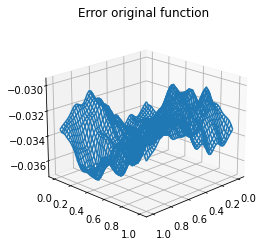

In [18]:
fig = plt.figure()
ax1 = plt.axes(projection='3d')
x = x.reshape(M_plot,M_plot)
y = y.reshape(M_plot,M_plot)
function_error = z_model - z_true
ax1.plot_wireframe(x,y,function_error)
ax1.view_init(20,45)
ax1.set_title("Error original function")